## GLANCE: Global Actions In A Nutshell for Counterfactual Explainability

**GLANCE** is a versatile and adaptive framework, introduced in our [respective paper](https://arxiv.org/abs/2405.18921), for generating *global counterfactual explanations*. <br>
These explanations are expressed as actions that offer recourse to large population subgroups.<br> The framework aims to provide explanations and insights, ensuring that the actions benefit as many individuals as possible.

GLANCE consists of two algorithms: 

- **C-GLANCE** that employs a clustering-based approach, ideal for explaining and debugging the model
- **T-GLANCE** that employs a tree-based approach, ideal for policy-making and auditing.

In this notebook, we will explore how to use these algorithms effectively.

We will use the Adult Dataset from the UCI Machine Learning Repository ([reference](https://archive.ics.uci.edu/dataset/2/adult)).<br>
Adult Dataset is a widely used collection of demographic information derived from the 1994 U.S. Census database. It includes features such as age, work class,<br> education level, marital status, occupation, relationship, race, sex, hours worked per week and the target variable is whether an individual earns more than $50,000 per year,<br> making it a popular dataset for classification tasks in machine learning.


## Preliminaries

### Import Dependencies 
As usual in python, the first step is to import all necessary packages.



In [1]:
from xgboost import XGBClassifier
import pandas as pd
from aix360.algorithms.glance.iterative_merges.iterative_merges import C_GLANCE
from aix360.algorithms.glance.counterfactual_tree.counterfactual_tree import T_GLANCE
from aix360.datasets.adult_dataset import AdultDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Load Dataset


In [2]:
data = AdultDataset()
df = data.dataframe()
df.head()

Using Adult dataset:  c:\users\nikolastheol\documents\github\aix360\aix360\datasets\..\data\adult_data\adult.csv


,Age,Workclass,Education,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,Status
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Example Model to be used for explanations
We use the train set to train a simple XGBoostClassifier. This will serve as the demonstrative model, which we will then treat as a black box and apply our algorithm.

Of course, any model can be used in its place.



In [3]:
df = df.sample(frac=0.01, random_state=42)
X = df.drop(columns='Status')
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
num_features = X_train._get_numeric_data().columns.to_list()
cate_features = X_train.columns.difference(num_features)

In [4]:
model = XGBClassifier()
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            cate_features,
        )
    ],
    remainder="passthrough",
)
_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)
_model.fit(X_train,y_train)
predictions = _model.predict(X_test)

GLANCE focuses on the population that has obtained the unfavorable outcome (affected population) (affected population) by a ML model.<br> It aims to find the *s* global actions that, if applied, the specific population will achieve the favorable outcome.<br>
<br>
For this reason, our first step is to identify the affected population, as it serves as input to the algorithm.

In [5]:
affected = X_test[predictions == 0].reset_index(drop=True)
train_dataset = df.copy()


for col in num_features:
    train_dataset[col] = train_dataset[col].astype(float)
    
train_dataset["target"] = df['Status']
train_dataset.drop(columns='Status',inplace=True)

#feat_to_vary is a variable used by DiCE counterfactual explanation
feat_to_vary = list(affected.columns)
target_name = "Status"

## A Practical Example of GLANCE

## C-GLANCE 
C-GLANCE is a clustering-based algorithm designed to generate global counterfactual explanations. <br>It starts by forming initial clusters and gradually merges them until the number of clusters matches the user-defined final_clusters parameter.<br> From each of these final clusters, the best action is selected, and together, these actions form the global explanation.

C-GLANCE framework is loaded with:
 - the model to be explained
 - number of initial clusters, 
 - number of final clusters, from each of which the best action is extracted
 - number of local counterfactuals, that the Local Counterfactual Method generates for each centroid of the initial clusters

 C-GLANCE algorithm allows the users to specify the number of global actions generated and serves as a tool to explain and debug ML models.

In [6]:
global_method = C_GLANCE(
    _model, # model to be explained
    initial_clusters=40, # starting number of clusters
    final_clusters=3, # number of final clusters after merging, from each of which the best action is extracted
    num_local_counterfactuals=10, # number of counterfactuals the Local Counterfactual Method generates for each centroid of the initial clusters
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary, # DiCE parameter that chooses which features to change in order to generate counterfactuals
    cf_generator="Dice"
)

clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Action 1 
Education = Bachelors 
Capital-Gain +48937.7 

Effectiveness: 100.00%	Cost: 5.79


Action 2 
Age +10.0 
Capital-Gain +32792.9 

Effectiveness: 100.00%	Cost: 4.65


Action 3 
Marital-Status = Separated 
Capital-Gain +71470.0 
Hours-Per-Week +32.3 

Effectiveness: 100.00%	Cost: 11.47


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 5.81


c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:1032: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


## C-GLANCE Output
C-GLANCE generates a set of final actions, with a focus on their overall impact when applied to the entire affected population. While each action is initially associated with a specific cluster, the key metrics we prioritize are the *Total Effectiveness* and *Total Cost* across the whole population.

- *Total Effectiveness* is the percentage of individuals that achieve the favorable outcome, if each one of the final actions is applied to the whole affected population.<br>
- *Total Cost* is calculated as the mean recourse cost of the whole set of final actions over the entire population.

Additionally, for each generated action the suggested changes are also reported, as well as the *effectiveness* and *cost* they achieve on the population of the cluster they were extracted from. More specifically:

- *Effectiveness*, for each cluster-action pair ($C$, $a$), represents the percentage of individuals in $C$ who get the favorable outcome when the action $a$ is applied.
<br>
- *Cost*, for each cluster-action pair ($C$, $a$), is the mean recourse cost computed when the action $a$ is applied to the individuals of cluster $C$.
<br>

In the above output of C-GLANCE algorithm we can see the 3 actions computed.<br>
For example:


**Action 1** <br>
**Education =**  <span style="color: red;">Bachelors</span><br>
**Capital-Gain =**  <span style="color: red;">+48937.7</span><br>
**Effectiveness**: <span style="color: green;">100.00%</span>	                **Cost**: <span style="color: purple;">5.79</span><br>
Action 1 corresponds to the affected individuals of cluster 1 from the 3 final clusters, and suggests that if the affected individuals change their education to Bachelors Degree and increase their capital-gain for 48937,7 they will **all** get the favorable outcome as the respective Effectiveness for Action 1 is **100.0%**.<br>
In the same manner we can explain the other 2 Actions and their respective metrics.

**Action 2** <br>
**Age =**  <span style="color: red;">+10.0</span><br>
**Capital-Gain =**  <span style="color: red;">+32792.9</span><br>
**Effectiveness**: <span style="color: green;">100.00%</span>	                **Cost**: <span style="color: purple;">4.65</span><br>
Action 2 corresponds to the affected individuals of cluster 2 from the 3 final clusters, and suggests that if the affected individuals were 10 years older and increased their capital-gain for +32792.9 they will **all** get the favorable outcome as the respective Effectiveness for Action 2 is **100.0%**.<br>

**Action 3** <br>
**Marital-Status =**  <span style="color: red;">Seperated</span><br>
**Capital-Gain =**  <span style="color: red;">+71470.0</span><br>
**Hours-Per-Week =**  <span style="color: red;">+32.3</span><br>
**Effectiveness**: <span style="color: green;">100.00%</span>	                **Cost**: <span style="color: purple;">11.47</span><br>
Action 3 corresponds to the affected individuals of cluster 3 from the 3 final clusters, and suggests that if the affected individuals had Seperated as marital status, increased their capital-gain for +71470.0 and increased their working hours per week for 32.3 hours more they will **all** get the favorable outcome as the respective Effectiveness for Action 3 is **100.0%**.<br>

In the end of the ouput the *Total Effectiveness* and *Total Cost* is showcased.<br><br>
**TOTAL EFFECTIVENESS:** <span style="color: green;">100.00%</span><br>
**TOTAL COST** <span style="color: purple;">5.81</span><br>

## C-GLANCE Modularity
Our framework is highly **modular**, allowing users to customize various aspects of it. <br>

Specifically:
- **Choice of Local Counterfactual Methods**: Users can select from a variety of local counterfactual methods to generate candidate counterfactual explanations, such as:
    - **NearestNeighbors**: When queried to provide *k* counterfactuals for an affected individual, it retrieves the k nearest neighbors from the set of unaffected instances based on their proximity to the affected individual.
    - **Random Sampling**: To find counterfactuals for an affected instance, this method iteratively modifies its features one at a time. The process begins by randomly altering one feature at a time, generating multiple new candidate instances

- **Strategy for Selecting Actions**: Additionally, users can choose different strategies for selecting the best actions from the generated counterfactuals. This enables fine-tuning of the process, allowing for the optimal balance between effectiveness and recourse cost, based on user-defined preferences.
    - **max-eff** : Selects actions based on maximizing the effectiveness.
    - **low-cost** : Selects the action with the lowest cost that flips a sufficient number of instances.
    - **mean-act** : Selects the mean action from a set of candidate actions.

In order to use them, the user should provide the **fit** method with the **cf_generator** and **cluster_action_choice_algo** variables and choose the methods of his/hers liking.

In [7]:
global_method = C_GLANCE(
    _model, initial_clusters=100, final_clusters=3, num_local_counterfactuals=10
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary,
    cluster_action_choice_algo = 'max-eff',
    cf_generator="RandomSampling",
)

In [8]:
clusters, clusters_res = global_method.explain_group(affected)

c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:294: UserWarning: Requested number of initial clusters is larger than the number of instances to explain. Setting to number of instances.
  warnings.warn(
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:1032: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
Education = Bachelors 
Capital-Gain +13360.410752281923 

Effectiveness: 100.00%	Cost: 2.17


Action 2 
Occupation = Transport-moving 
Capital-Gain +16762.525423024712 

Effectiveness: 100.00%	Cost: 2.68


Action 3 
Occupation = Prof-specialty 
Capital-Gain +17762.44715992576 

Effectiveness: 100.00%	Cost: 2.59


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 2.25


## T-GLANCE
T-GLANCE is the second algorithm of the GLANCE framework that generates global counterfactual explanations using a decision tree-like structure.

In contrast to C-GLANCE where users specify the number of the final actions to be generated, T-GLANCE allows the users to specify the split features when building the decision tree.<br>

This characteristic of T-GLANCE makes it ideal for finding actions that can serve as subgroup policies, for the subgroups corresponding to the nodes of the tree.

T-GLANCE framework is loaded with:
 - the model to be explained,
 - split_features, the specified features to be used in the splits, if **None** we provide suggestions based feature permutation score of the features.


T-GLANCE is also modular, as the user can specify in which way the actions of each node(subgroup) are computed.<br>
This can be either a Local Counterfactual Explanation Method (**local_method** parameter) or a Global Counterfactual Explanation Method (**global_method** parameter).

In [9]:
cf_tree = T_GLANCE(_model, 
                   split_features=None,
                   local_method='Dice')

cf_tree.fit(X, y, train_dataset)
node = cf_tree.partition_group(affected)

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


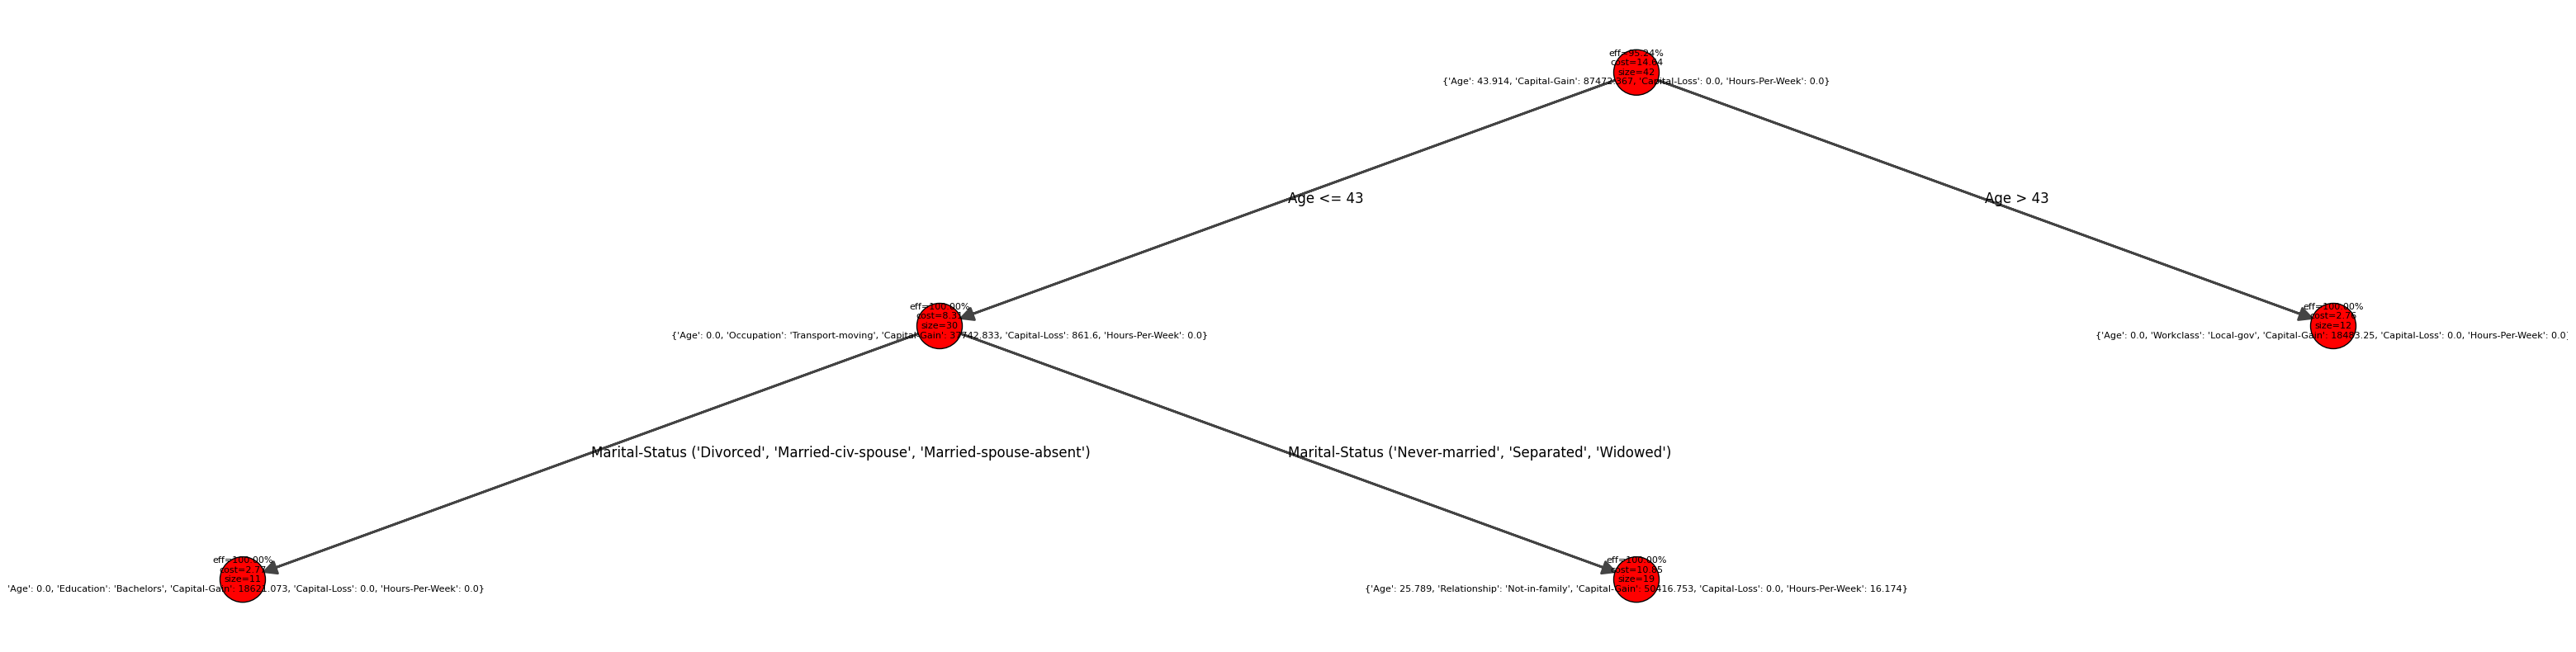

In [10]:
node.display_igraph_jupyter(
    numeric_features=affected.select_dtypes(
        include=["number"]).columns.tolist()
)

In [11]:
eff, cost, length = cf_tree.cumulative_leaf_actions()


TOTAL EFFECTIVENESS: 100.00%

TOTAL COST: 4.27


## T-GLANCE Output
The output of the T-GLANCE algorithm consists of a visual representation of the decision tree in which the user can inspect the subgroups created by the chosen split features and the respective actions along with their *Effectiveness* and *Cost*.

*Effectiveness* and *Cost* are computed for the population of each node of the tree, similar to the way they were computed for each final cluster in  C-GLANCE.

*Total Effectiveness* and *Total Cost* are computed in the same manner as in C-GLANCE, with the only difference being that the set of actions being evaluated are the ones that correspond to the leaf nodes of the tree.

More specifically, in the above output of T-GLANCE the end user can see that 3 subgroups were created using as split features the **Age** and **Marital-Status**.<br>
For example, the user can inspect that the individuals corresponding to the bottom right node belong to the subgroup with **Age <= 43** and **Marital-Status{Never-Married,Seperated,Widowed}**.<br>

By applying the action **{Age:25.789, Relationship: Not-In-Family, Capital-Gain: 50416,753, Capital-Loss: 0.0, Hours-Per-Week: 16,174}** that is showcased in the bottom of the node, all individuals can get the favorable outcome as the *effectiveness* on this node is **100.00%** with a cost of 10.85. <br> Value 0.0 for feature Capital-Loss suggests that this action does not alter the specific feature.

As a practical example of the auditing capabilities of T-GLANCE, one can observe the node described previously in contrast to the right child of the root node. More specifically, this node corresponds to individuals with **Age > 43**, with the optimal suggested action being **{Age:0.0, Workclass: Local-Gov, Capital-Gain: 18483,25, Capital-Loss: 0.0, Hours-Per-Week: 0.0}** with *effectiveness* of **100.00%** and cost 2.76.

By comparing the suggested actions for the two subgroups, the user can gain the insight that individuals having **Age > 43** need only to change their workclass and raise their capital-gain while the individuals belonging to **Age <= 43** and **Marital-Status{Never-Married,Seperated,Widowed}** subgroup have to increase their capital-gain much more and also increase their hours-per-week and their age and also change their relationship-status.